In [1]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
 
import tensorflow as tf
import tensorflow.keras.datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'bicyclist', 'void']

train_image_path = 'dataset1/images_prepped_train/'
train_label_path = 'dataset1/annotations_prepped_train/'
test_image_path = 'dataset1/images_prepped_test/'
test_label_path = 'dataset1/annotations_prepped_test/'
 
BATCH_SIZE = 8

In [3]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=224, width=224):
    '''
    Preprocesses the dataset by:
        * resizing the input image and label maps
        * normalizing the input image pixels
        * reshaping the label maps from (height, width, 1) to (height, width, 12)
    
    Args:
        t_filename(string) -- path to the raw input image
        a_filename(string) -- path to the raw annotation (label map) file
        height(int) -- height in pixels to resize to
        width(int) -- width in pixels to resize to
    
    Returns:
        image(tensor) -- preprossed image
        annotation(tensor) -- preprocessed annotation
    '''
 
    # Convert image and mask files to tensors
    img_raw = tf.io.read_file(t_filename)
    anno_raw = tf.io.read_file(a_filename)
    image = tf.image.decode_jpeg(img_raw)
    annotation = tf.image.decode_jpeg(anno_raw)
 
    # Resize image and segmentation mask
    image = tf.image.resize(image, (height, width,))
    annotation = tf.image.resize(annotation, (height, width,))
    image = tf.reshape(image, (height, width, 3,))
    annotation = tf.cast(annotation, dtype=tf.int32)
    annotation = tf.reshape(annotation, (height, width, 1,))
    stack_list = []
 
    # Reshape segmentation masks
    for c in range(len(class_names)):
        mask = tf.equal(annotation[:,:,0], tf.constant(c))
        stack_list.append(tf.cast(mask, dtype=tf.int32))
    
    annotation = tf.stack(stack_list, axis=2)
 
    # Normalize pixels in the input image
    image = image / 127.5
    image -= 1
 
    return image, annotation
 
def get_dataset_slice_paths(image_dir, label_map_dir):
    '''
    generates the lists of image and label map paths
  
    Args:
        image_dir (string) -- path to the input images directory
        label_map_dir (string) -- path to the label map directory
 
    Returns:
        image_paths (list of strings) -- paths to each image file
        label_map_paths (list of strings) -- paths to each label map
    '''
 
    image_file_list = os.listdir(image_dir)
    label_map_file_list = os.listdir(label_map_dir)
    image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
    label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]
 
    return image_paths, label_map_paths
 
def get_training_dataset(image_paths, label_map_paths):
    '''
    Prepares shuffled batches of the training set.
  
    Args:
        image_dir (string) -- path to the input images directory
        label_map_dir (string) -- path to the label map directory
 
    Returns:
        tf Dataset containing the preprocessed train set
    '''
    training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
    training_dataset = training_dataset.map(map_filename_to_image_and_mask)
    training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
    training_dataset = training_dataset.batch(BATCH_SIZE)
    training_dataset = training_dataset.repeat()
    training_dataset = training_dataset.prefetch(-1)
 
    return training_dataset
 
def get_validation_dataset(image_paths, label_map_paths):
    '''
    Prepares shuffled batches of the validation set.
  
    Args:
        image_dir (string) -- path to the input images directory
        label_map_dir (string) -- path to the label map directory
 
    Returns:
        tf Dataset containing the preprocessed train set
    '''
    validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
    validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
    validation_dataset = validation_dataset.batch(BATCH_SIZE)
    validation_dataset = validation_dataset.repeat()
 
    return validation_dataset

In [4]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths(train_image_path, train_label_path)
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths(test_image_path, test_label_path)
# generate the train and valid sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


In [5]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))
 
# print class name - normalized RGB tuple pairs
# the tuple values will be multiplied by 255 in the helper functions later
# to convert to the (0,0,0) to (255,255,255) RGB values you might be familiar with
for class_name, color in zip(class_names, colors):
    print(f'{class_name} -- {color}')


sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
bicyclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


In [6]:
# Visualization Utilities
 
def fuse_with_pil(images):
    '''
    Creates a blank image and pastes input images
 
    Args:
        images (list of numpy arrays) - numpy array representations of the images to paste
  
    Returns:
        PIL Image object containing the images
    '''
 
    widths = (image.shape[1] for image in images)
    heights = (image.shape[0] for image in images)
    total_width = sum(widths)
    max_height = max(heights)
 
    new_im = PIL.Image.new('RGB', (total_width, max_height))
 
    x_offset = 0
    for im in images:
        pil_image = PIL.Image.fromarray(np.uint8(im))
        new_im.paste(pil_image, (x_offset,0))
        x_offset += im.shape[1]
  
    return new_im
 
 
def give_color_to_annotation(annotation):
    '''
    Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
    the third axis represents the color channel. The label values are multiplied by
    255 and placed in this axis to give color to the annotation
 
    Args:
        annotation (numpy array) - label map array
  
    Returns:
        the annotation array with an additional color channel/axis
    '''
    seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
    for c in range(12):
        segc = (annotation == c)
        seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
        seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
        seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
    return seg_img
 
 
def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
    '''
    Displays the images with the ground truth and predicted label maps
 
    Args:
        image (numpy array) -- the input image
        labelmaps (list of arrays) -- contains the predicted and ground truth label maps
        titles (list of strings) -- display headings for the images to be displayed
        iou_list (list of floats) -- the IOU values for each class
        dice_score_list (list of floats) -- the Dice Score for each vlass
    '''
 
    true_img = give_color_to_annotation(labelmaps[1])
    pred_img = give_color_to_annotation(labelmaps[0])
 
    image = image + 1
    image = image * 127.5
    images = np.uint8([image, pred_img, true_img])
 
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
    display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list) 
 
    plt.figure(figsize=(15, 4))
 
    for idx, im in enumerate(images):
        plt.subplot(1, 3, idx+1)
        if idx == 1:
            plt.xlabel(display_string)
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[idx], fontsize=12)
        plt.imshow(im)
 
 
def show_annotation_and_image(image, annotation):
    '''
    Displays the image and its annotation side by side
 
    Args:
        image (numpy array) -- the input image
        annotation (numpy array) -- the label map
    '''
    new_ann = np.argmax(annotation, axis=2)
    seg_img = give_color_to_annotation(new_ann)
  
    image = image + 1
    image = image * 127.5
    image = np.uint8(image)
    images = [image, seg_img]
  
    images = [image, seg_img]
    fused_img = fuse_with_pil(images)
    plt.imshow(fused_img)
 
 
def list_show_annotation(dataset):
    '''
    Displays images and its annotations side by side
 
    Args:
        dataset (tf Dataset) - batch of images and annotations
    '''
 
    ds = dataset.unbatch()
    ds = ds.shuffle(buffer_size=100)
 
    plt.figure(figsize=(25, 15))
    plt.title("Images And Annotations")
    plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)
 
    # we set the number of image-annotation pairs to 9
    # feel free to make this a function parameter if you want
    for idx, (image, annotation) in enumerate(ds.take(9)):
        plt.subplot(3, 3, idx + 1)
        plt.yticks([])
        plt.xticks([])
        show_annotation_and_image(image.numpy(), annotation.numpy())

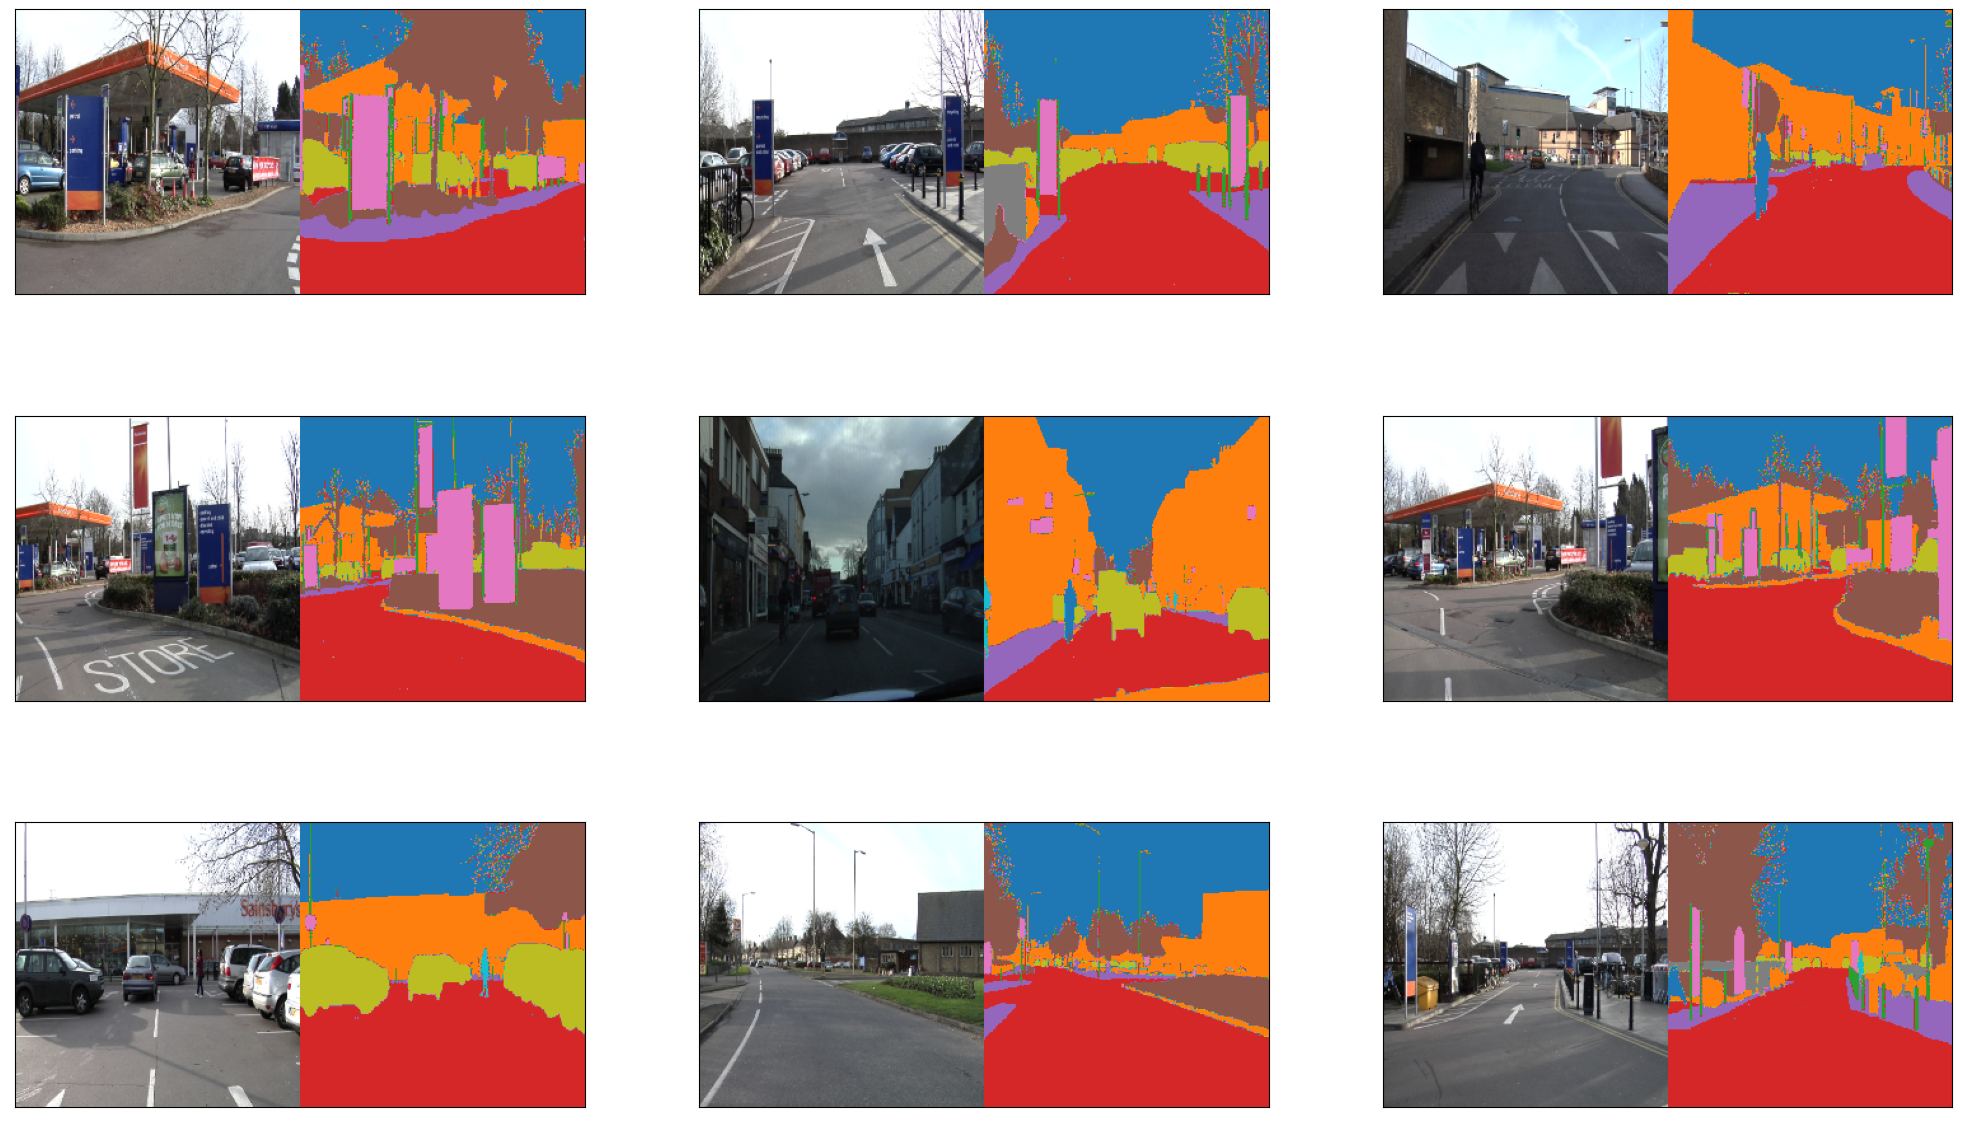

In [7]:
list_show_annotation(training_dataset)

In [8]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
    '''
    Defines a block in the VGG block
 
    Args:
        x(tensor) -- input image
        n_convs(int) -- number of convolution lyaers to append
        filters(int) -- number of filters for the convolution lyaers
        activation(string or object) -- activation to use in the convolution
        pool_size(int) -- size of the pooling layer
        pool_stride(int) -- stride of the pooling layer
        block_name(string) -- name of the block
    
    Returns:
        tensor containing the max-pooled output of the convolutions
    '''
    for i in range(n_convs):
        x = tf.keras.layers.Conv2D(filters=filters,
                                   kernel_size=kernel_size,
                                   activation=activation,
                                   padding='same',
                                   name=f'{block_name}_conv{i+1}')(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=pool_size,
                                     strides=pool_stride,
                                     name=f'{block_name}_pool{i+1}')(x)
    
    return x

In [9]:
# assign to a variable
vgg_weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"


In [10]:
def VGG_16(image_input):
    '''
    This function defines the VGG encoder.
 
    Args:
        image_input(tensor) -- batch of images
    
    Returns:
        tuple of tensors -- output of all encoder blocks plus the final convolution layer
    '''
 
    # create 5 blocks with increasing filters at each stage
    x = block(image_input, n_convs=2, filters=64, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block1')
    p1 = x # (112, 112, 64)
 
    x = block(x, n_convs=2, filters=128, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block2')
    p2 = x # (56, 56, 128)
 
    x = block(x, n_convs=3, filters=256, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block3')
    p3 = x # (28, 28, 256)
 
    x = block(x, n_convs=3, filters=512, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block4')
    p4 = x # (14, 14, 512)
 
    x = block(x, n_convs=3, filters=512, kernel_size=(3,3), activation='relu',
              pool_size=(2,2), pool_stride=(2,2),
              block_name='block5')
    p5 = x # (7, 7, 512)
 
    # create the vgg model
    vgg = tf.keras.Model(image_input, p5)
 
    # load the pretrained weights downloaded
    vgg.load_weights(vgg_weights_path)
 
    # number of filters for the output convolutional layers
    n = 4096
 
    # our input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
    # we can extract more features by chaining two more convolution layers.
    c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
    c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)
 
    # return the outputs at each stage. you will only need two of these in this particular exercise 
    # but we included it all in case you want to experiment with other types of decoders.
    return (p1, p2, p3, p4, c7)

In [11]:
def decoder(convs, n_classes):
    '''
    Defines the FCN 32,16,8 decoder.
 
    Args:
        convs(tuple of tensors) -- output of the encoder network
        n_classes(int) -- number of classes
    
    Returns:
        tensor with shape (height, width, n_classes) contating class probabilities(FCN-32, FCN-16, FCN-8)
    '''
 
    # unpack the output of the encoder
    f1, f2, f3, f4, f5 = convs 
    """f1 = (112, 112, 64)
       f2 = (56, 56, 128)
       f3 = (28, 28, 256)
       f4 = (14, 14, 512)
       f5 = (7, 7, 512) """
 
    # FCN-32 output
    fcn32_o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(32,32), strides=(32, 32), use_bias=False)(f5)
    fcn32_o = tf.keras.layers.Activation('softmax')(fcn32_o)
 
    # upsample the output of the encoder then crop extra pixels that were introduced
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=False)(f5) # (16, 16, n)
    o = tf.keras.layers.Cropping2D(cropping=(1,1))(o) # (14, 14, n)
 
    # load the pool4 prediction and do a 1x1 convolution to reshape it to the same shape of 'o' above
    o2 = f4 # (14, 14, 512)
    o2 = tf.keras.layers.Conv2D(n_classes, (1,1), activation='relu', padding='same')(o2) # (14, 14, n)
 
    # add the result of the upsampling and pool4 prediction
    o = tf.keras.layers.Add()([o, o2]) # (14, 14, n)
 
    # FCN-16 output
    fcn16_o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(16,16), strides=(16,16), use_bias=False)(o)
    fcn16_o = tf.keras.layers.Activation('softmax')(fcn16_o)
 
    # upsample the resulting tensor of the operation you just did
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=False)(o) # (30, 30, n)
    o = tf.keras.layers.Cropping2D(cropping=(1,1))(o) # (28, 28, n)
 
    # load the pool3 prediction and do a 1x1 convolution to reshape it to shame shape of 'o' above
    o2 = f3 # (28, 28, 256)
    o2 = tf.keras.layers.Conv2D(n_classes, (1,1), activation='relu', padding='same')(o2) # (28, 28, n)
 
    # add the result of the upsampling and pool3 prediction
    o = tf.keras.layers.Add()([o, o2]) # (28, 28, n)
 
    # upsample up to the size of the original image
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(8,8), strides=(8,8), use_bias=False)(o) # (224, 224, n)
 
    # append a softmax to get the class probabilities
    fcn8_o = tf.keras.layers.Activation('softmax')(o)
 
    return fcn32_o, fcn16_o, fcn8_o

In [13]:
def segmentation_model():
    '''
    Defines the final segmentation model by chaining together the encoder and decoder.
 
    Returns:
        Keras Model that connects the encoder and decoder networks of the segmentation model
    '''
 
    inputs = tf.keras.layers.Input(shape=(224,224,3,))
    convs = VGG_16(inputs)
    fcn32, fcn16, fcn8 = decoder(convs, 12)
    model_fcn32 = tf.keras.Model(inputs, fcn32)
    model_fcn16 = tf.keras.Model(inputs, fcn16)
    model_fcn8 = tf.keras.Model(inputs, fcn8)
 
    return model_fcn32, model_fcn16, model_fcn8
    
model_fcn32, model_fcn16, model_fcn8 = segmentation_model()

ERROR! Session/line number was not unique in database. History logging moved to new session 195


In [14]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True)
model_fcn32.compile(loss='categorical_crossentropy',
                    optimizer=sgd,
                    metrics=['acc'])
model_fcn16.compile(loss='categorical_crossentropy',
                    optimizer=sgd,
                    metrics=['acc'])
model_fcn8.compile(loss='categorical_crossentropy',
                   optimizer=sgd,
                   metrics=['acc'])

In [15]:
#train the model

# number of training images
train_count = len(training_image_paths)
 
# number of validation images
valid_count = len(validation_image_paths)
 
EPOCHS = 170
 
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = valid_count//BATCH_SIZE


# FCN 32
history_fcn32 = model_fcn32.fit(training_dataset,
                                steps_per_epoch=steps_per_epoch,
                                validation_data=validation_dataset,
                                validation_steps=validation_steps,
                                epochs=50)

Train for 45 steps, validate for 12 steps
Epoch 1/50
45/45 [==============================] - 35s 768ms/step - loss: 2.4747 - acc: 0.2649 - val_loss: 2.4343 - val_acc: 0.3192
Epoch 2/50
45/45 [==============================] - 31s 691ms/step - loss: 1.7073 - acc: 0.4632 - val_loss: 1.2740 - val_acc: 0.5573
Epoch 3/50
45/45 [==============================] - 28s 623ms/step - loss: 1.0902 - acc: 0.6399 - val_loss: 1.1562 - val_acc: 0.6116
Epoch 4/50
45/45 [==============================] - 28s 624ms/step - loss: 0.9729 - acc: 0.6818 - val_loss: 0.9879 - val_acc: 0.6347
Epoch 5/50
45/45 [==============================] - 28s 624ms/step - loss: 0.8606 - acc: 0.7254 - val_loss: 0.8761 - val_acc: 0.7474
Epoch 6/50
45/45 [==============================] - 28s 626ms/step - loss: 0.7854 - acc: 0.7612 - val_loss: 0.7445 - val_acc: 0.7899
Epoch 7/50
45/45 [==============================] - 28s 626ms/step - loss: 0.6863 - acc: 0.7945 - val_loss: 0.6901 - val_acc: 0.8065
Epoch 8/50
45/45 [=========

In [ ]:
from tensorflow.keras.optimizers import Adam
model_fcn16.compile(loss='categorical_crossentropy',
                    optimizer='Adam',
                    metrics=['acc'])
history_fcn16 = model_fcn16.fit(training_dataset,
                                steps_per_epoch=steps_per_epoch,
                                validation_data=validation_dataset,
                                validation_steps=validation_steps,
                                epochs=100)

ERROR! Session/line number was not unique in database. History logging moved to new session 201
Train for 45 steps, validate for 12 steps
Epoch 1/100
 1/45 [..............................] - ETA: 8:16

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tlsdu\AppData\Local\Temp\ipykernel_13664\1730318469.py", line 9, in <module>
    epochs=100)
  File "C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 128, in run_one_epoch
    batch_outs = execution_function(iterator)
  File "C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2_utils.py", line 98, in execution_function
    distri

In [17]:
from tensorflow.keras.optimizers import Adam
model_fcn8.compile(loss='categorical_crossentropy',
                   optimizer='Adam',
                   metrics=['acc'])
history_fcn8 = model_fcn8.fit(training_dataset,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=validation_dataset,
                              validation_steps=validation_steps,
                              epochs=100)

ERROR! Session/line number was not unique in database. History logging moved to new session 198
Train for 45 steps, validate for 12 steps
Epoch 1/100
45/45 [==============================] - 24s 533ms/step - loss: 2.3958 - acc: 0.2463 - val_loss: 1.8832 - val_acc: 0.4427
Epoch 2/100
45/45 [==============================] - 23s 504ms/step - loss: 1.3689 - acc: 0.5715 - val_loss: 1.3163 - val_acc: 0.5849
Epoch 3/100
45/45 [==============================] - 22s 490ms/step - loss: 1.0777 - acc: 0.6721 - val_loss: 1.1794 - val_acc: 0.6039
Epoch 4/100
45/45 [==============================] - 22s 489ms/step - loss: 0.9778 - acc: 0.6893 - val_loss: 1.0689 - val_acc: 0.6017
Epoch 5/100
45/45 [==============================] - 22s 492ms/step - loss: 0.9036 - acc: 0.7064 - val_loss: 1.0639 - val_acc: 0.6192
Epoch 6/100
45/45 [==============================] - 22s 491ms/step - loss: 0.8738 - acc: 0.7144 - val_loss: 1.0285 - val_acc: 0.6160
Epoch 7/100
45/45 [==============================] - 22s 4

Epoch 61/100
45/45 [==============================] - 22s 492ms/step - loss: 0.2087 - acc: 0.9404 - val_loss: 0.5722 - val_acc: 0.8662
Epoch 62/100
45/45 [==============================] - 22s 493ms/step - loss: 0.2044 - acc: 0.9418 - val_loss: 0.5562 - val_acc: 0.8650
Epoch 63/100
45/45 [==============================] - 22s 491ms/step - loss: 0.2003 - acc: 0.9428 - val_loss: 0.5770 - val_acc: 0.8698
Epoch 64/100
45/45 [==============================] - 22s 491ms/step - loss: 0.2004 - acc: 0.9427 - val_loss: 0.5753 - val_acc: 0.8661
Epoch 65/100
45/45 [==============================] - 22s 492ms/step - loss: 0.2003 - acc: 0.9428 - val_loss: 0.5823 - val_acc: 0.8673
Epoch 66/100
45/45 [==============================] - 22s 492ms/step - loss: 0.1958 - acc: 0.9441 - val_loss: 0.5863 - val_acc: 0.8680
Epoch 67/100
45/45 [==============================] - 22s 492ms/step - loss: 0.1901 - acc: 0.9458 - val_loss: 0.6069 - val_acc: 0.8639
Epoch 68/100
45/45 [==============================] - 2

In [19]:
def get_images_and_segments_test_arrays():
    '''
    Gets a subsample of the val set as your test set
 
    Returns:
        Test set contatining ground truth images and label maps
    '''
 
    y_true_segments = []
    y_true_images = []
    test_count = 64
 
    ds = validation_dataset.unbatch()
    ds = ds.batch(101)
 
    for image, annotation in ds.take(1):
        y_true_images = image
        y_true_segments = annotation
    
    y_true_segments = y_true_segments[:test_count, :, :, :]
    y_true_segments = np.argmax(y_true_segments, axis=3)
 
    return y_true_images, y_true_segments
 
# load the ground truth images and segmentation masks
y_true_images, y_true_segments = get_images_and_segments_test_arrays()

In [20]:
# get the model prediction
results_fcn32 = model_fcn32.predict(validation_dataset, steps=validation_steps)
results_fcn16 = model_fcn16.predict(validation_dataset, steps=validation_steps)
results_fcn8 = model_fcn8.predict(validation_dataset, steps=validation_steps)
 
# for each pixel, get the slice number which has the highest probaility
results_fcn32 = np.argmax(results_fcn32, axis=3)
results_fcn16 = np.argmax(results_fcn16, axis=3)
results_fcn8 = np.argmax(results_fcn8, axis=3)

In [21]:
def compute_metrics(y_true, y_pred):
    '''
    Compute IoU and Dice Score
 
    Args:
        y_true(tensor) -- ground truth label map
        y_pred(tensor) -- predicted label map
    '''
 
    class_wise_iou = []
    class_wise_dice_score = []
 
    smoothening_factor = 0.00001
 
    for i in range(12):
        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area
 
        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)
 
        dice_score = 2*((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)
 
    return class_wise_iou, class_wise_dice_score

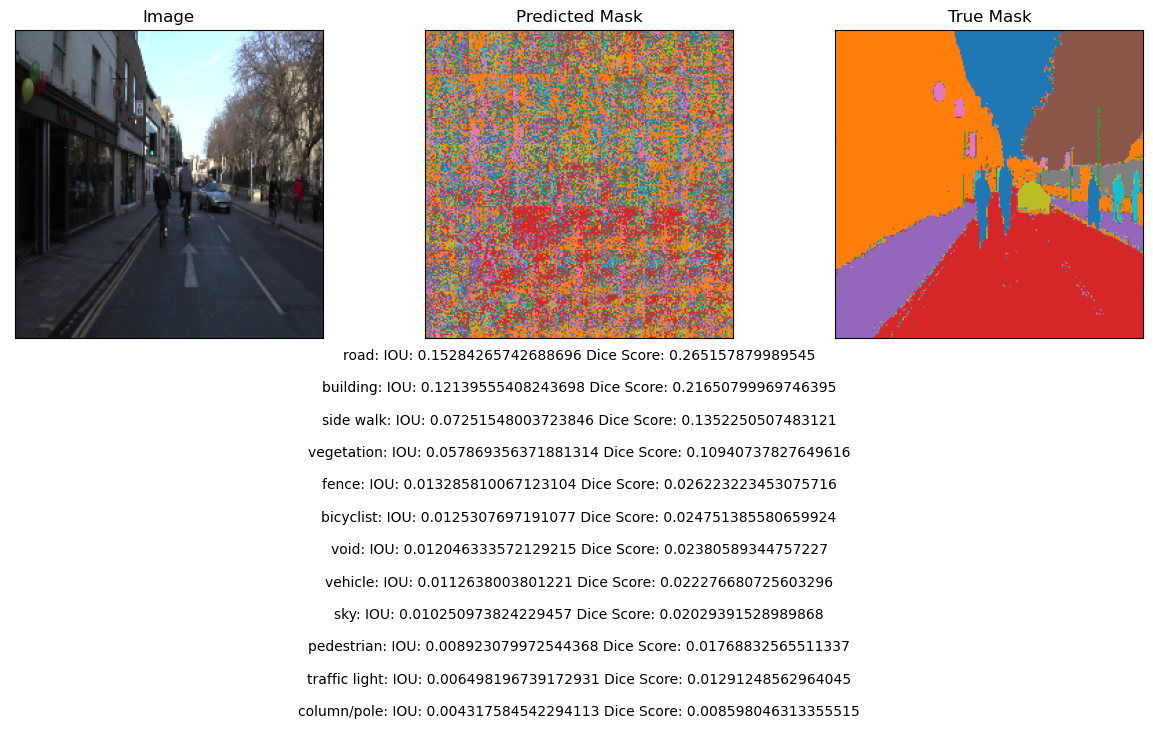

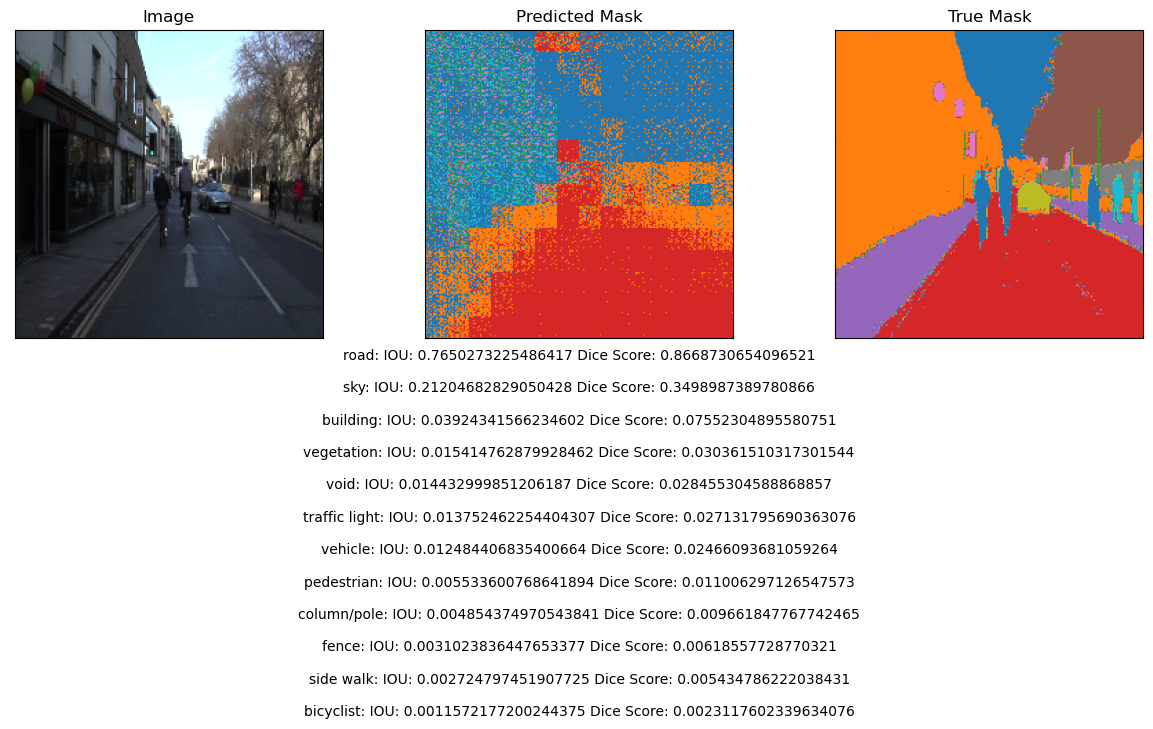

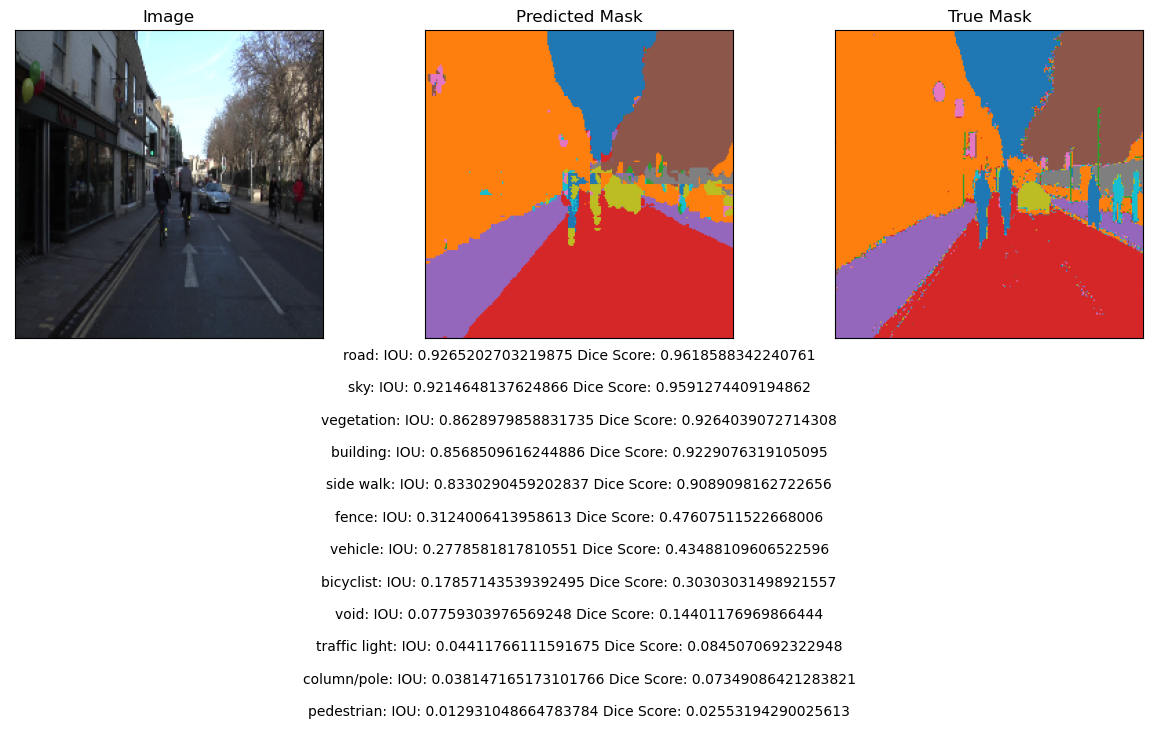

In [22]:
# input a number from 0 to 63 to pick an image from the test set
integer_slider = 20
 
# compute metrics
iou_fcn32, dice_score_fcn32 = compute_metrics(y_true_segments[integer_slider], results_fcn32[integer_slider])
iou_fcn16, dice_score_fcn16 = compute_metrics(y_true_segments[integer_slider], results_fcn16[integer_slider])
iou_fcn8, dice_score_fcn8 = compute_metrics(y_true_segments[integer_slider], results_fcn8[integer_slider])
 
# visualize the output and metrics
show_predictions(y_true_images[integer_slider], [results_fcn32[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou_fcn32, dice_score_fcn32)
show_predictions(y_true_images[integer_slider], [results_fcn16[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou_fcn16, dice_score_fcn16)
show_predictions(y_true_images[integer_slider], [results_fcn8[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou_fcn8, dice_score_fcn8)


In [ ]:
# compute class-wise metrics
cls_wise_iou_fcn32, cls_wise_dice_score_fcn32 = compute_metrics(y_true_segments, results_fcn32)
cls_wise_iou_fcn16, cls_wise_dice_score_fcn16 = compute_metrics(y_true_segments, results_fcn16)
cls_wise_iou_fcn8, cls_wise_dice_score_fcn8 = compute_metrics(y_true_segments, results_fcn8)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tlsdu\AppData\Local\Temp\ipykernel_13664\1750137151.py", line 2, in <module>
    cls_wise_iou_fcn32, cls_wise_dice_score_fcn32 = compute_metrics(y_true_segments, results_fcn32)
  File "C:\Users\tlsdu\AppData\Local\Temp\ipykernel_13664\3498824791.py", line 16, in compute_metrics
    intersection = np.sum((y_pred == i) * (y_true == i))
ValueError: operands could not be broadcast together with shapes (96,224,224) (64,224,224) 

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

Duri